In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from fund.fund import Fund

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
market = Market()

In [3]:
delta_fund = Fund()
delta_fund.initialize()

In [4]:
market.connect()
sp100 = market.retrieve("sp100")
market.disconnect()

In [5]:
analysis = []
for strategy in tqdm(delta_fund.strategies):
    try:
        parameters = strategy.pull_iterations().to_dict("records")
        for parameter in tqdm(parameters):
            try:
                trade = strategy.db.query("trades",{"iteration":parameter["iteration"]})
                if trade.index.size > 0:
                    positions = int(strategy.positions) if strategy.pricer_class.asset_class.value == "stocks" else 1
                    pricer_timeframe =  strategy.pricer_class.time_horizon_class.naming_convention
                    trade = trade[trade["position"] <= positions]
                    ledger = trade.sort_values("date").copy()
                    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
                    anas = strategy.analysis
                    if ledger.index.size > 0:
                        cumulative = anas.trade_analysis(ledger,positions)
                        for key in parameter.keys():
                            cumulative[key] = parameter[key]
                        cumulative["strategy"] = strategy.name
                        analysis.append(cumulative[list(parameter.keys()) + ["strategy","pv"]].iloc[-1])
            except Exception as e:
                print(str(e))
                continue
        strategy.db.disconnect()
    except Exception as e:
        print(str(e))
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]


In [6]:
a.sort_values("pv",ascending=False).head(20)

,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,strategy,pv
7,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qsrr_b_r,6.212149
5,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qsrr_b_r,5.376271
23,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qsdr_b_r,5.169827
15,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qser_b_r,5.169827
13,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qser_b_r,4.391585
21,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qsdr_b_r,4.391585
47,100,False,1,False,False,0,1,7,strategy_qswp_qsrc_qsdr_b_r,4.244338
45,100,False,1,True,False,0,1,5,strategy_qswp_qsrc_qsdr_b_r,4.244338
39,100,False,1,False,False,0,1,7,strategy_qswp_qsrc_qser_b_r,4.244338
37,100,False,1,True,False,0,1,5,strategy_qswp_qsrc_qser_b_r,4.244338


In [7]:
top_by_strategy = a[a["constituent"]==100].sort_values("pv",ascending=False).groupby("strategy").nth(0).reset_index().sort_values("pv",ascending=False)

In [8]:
top_by_strategy

,strategy,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,pv
2,strategy_qsrp_qsrc_qsrr_b_r,100,False,1,False,False,0,1,7,6.212149
0,strategy_qsrp_qsrc_qsdr_b_r,100,False,1,False,False,0,1,7,5.169827
1,strategy_qsrp_qsrc_qser_b_r,100,False,1,False,False,0,1,7,5.169827
3,strategy_qswp_qsrc_qsdr_b_r,100,False,1,False,False,0,1,7,4.244338
4,strategy_qswp_qsrc_qser_b_r,100,False,1,False,False,0,1,7,4.244338
5,strategy_qswp_qsrc_qsrr_b_r,100,False,1,False,False,0,1,7,3.484918


In [9]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["strategy"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [10]:
cumulatives = []
ledgers = []
for row in top_by_strategy.iterrows():
    name = row[1]["strategy"]
    iteration = row[1]["iteration"]
    db = ADatabase(name)
    db.connect()
    analysis = db.query("trades",{"iteration":int(iteration)})
    db.disconnect()
    ledger = analysis[["date","ticker","actual_returns","position"]]
    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
    ledger = ledger.merge(sp100[["ticker","GICS Sector"]],on="ticker",how="left")
    ledger["strategy"] = name
    ledgers.append(ledger)
    portfolio = ledger.pivot_table(index="date",columns="position",values="actual_returns").fillna(1).reset_index()
    positions = ledger["position"].max()
    cumulative = anas.iteration_analysis(portfolio,positions)
    cumulative["strategy"] = name
    for i in range(positions):
        if i not in cumulative.columns:
            cumulative[i] = 1
        cumulative.rename(columns={i:str(i)},inplace=True)
    db.cloud_connect()
    db.drop("performance")
    db.store("performance",cumulative)
    db.disconnect()
    cumulatives.append(cumulative)

In [11]:
portfolio = pd.concat(cumulatives).pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(1).reset_index()
portfolio["pv"] = [sum([row[1][strategy]*(1/top_by_strategy.index.size) for strategy in portfolio.columns if strategy not in ["date"]]) for row in portfolio.iterrows()]

In [12]:
portfolio[["date","pv"]].tail(1)

strategy,date,pv
24,2023-03-21 04:00:00,4.992388


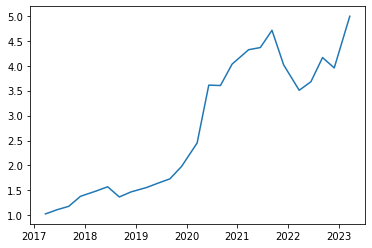

In [13]:
plt.plot(portfolio["date"],portfolio["pv"])

In [14]:
all_ledgers = pd.concat(ledgers)

In [15]:
all_ledgers.groupby(["strategy","GICS Sector"]).mean().reset_index().sort_values("actual_returns",ascending=False)

,strategy,GICS Sector,actual_returns,position
1,strategy_qsrp_qsrc_qsdr_b_r,Consumer Discretionary,1.184062,3.074074
12,strategy_qsrp_qsrc_qser_b_r,Consumer Discretionary,1.184062,3.074074
44,strategy_qswp_qsrc_qser_b_r,Consumer Discretionary,1.140278,4.031250
33,strategy_qswp_qsrc_qsdr_b_r,Consumer Discretionary,1.140278,4.031250
23,strategy_qsrp_qsrc_qsrr_b_r,Consumer Discretionary,1.131395,3.235294
...,...,...,...,...
16,strategy_qsrp_qsrc_qser_b_r,Health Care,0.998689,4.567568
42,strategy_qswp_qsrc_qsdr_b_r,Utilities,0.997364,5.333333
53,strategy_qswp_qsrc_qser_b_r,Utilities,0.997364,5.333333
31,strategy_qsrp_qsrc_qsrr_b_r,Utilities,0.965350,6.000000
